<a href="https://colab.research.google.com/github/bill-f/PyramidMaker/blob/master/fer2013project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Found GPU at: /device:GPU:0


In [0]:
from math import sqrt 
from PIL import Image
import pandas as pd
import os
import cv2

from matplotlib import cm
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

from tensorflow import keras

from keras.layers import Dense, Activation, Convolution2D, Dropout, Conv2D
from keras.layers import BatchNormalization
from keras.models import Sequential #Initialise our neural network model as a sequential network
from keras.layers import Flatten # Converting 2D arrays into a 1D linear vector
from keras.models import Model 
from keras.layers import Input
from keras.layers import MaxPooling2D # Maxpooling function
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.regularizers import l2
from keras.optimizers import Adam             
from keras.models import load_model, save_model #loading/saving models


# For decision tree
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

Using TensorFlow backend.


In [0]:
#connecting to google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#import fer2013.csv file

data = pd.read_csv('/content/drive/My Drive/fer2013.csv')

In [0]:
#read fer2013 format

data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [0]:
#count data by emotion

data.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

Each data sample has the below entries

emotion: one of the emotion represented as integer

pixels: pixel values for the image.

Usage: whether the sample should be used for training or test.

In [0]:
#create emotion array

num_classes = 7
width = 48
height = 48
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
classes=np.array(("Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"))

In [0]:
data.Usage.value_counts() 

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

We have a total of 35,887 images divided into three data sets:

Training - which we will use to train our model, by pairing the input with expected output.

PrivateTest - which will be used to validate our model on to fine tune model 
weights and biases.

PublicTest - this dataset will be used to evaluate our model after training is over. 

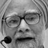

Angry


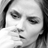

Fear


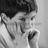

Sad


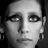

Neutral


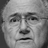

Fear


In [0]:
for i in range(1,6): 
    array = np.mat(data.pixels[i]).reshape(height, width) 
    image = Image.fromarray(np.uint8(array)) 
    display(image)
    #plt.imshow(image)
    print(emotion_labels[data.emotion[i]])

Spliting data to training / validation / testing. 
To form our input for the neural network, we take the three datasets defined above and reshape them to 48x48x1 numpy arrays


In [0]:
train_set = data[(data.Usage == 'Training')] 
X_train1 = np.array(list(map(str.split, train_set.pixels)), np.float32) #single array shape
X_train = X_train1.reshape(X_train1.shape[0], 48, 48, 1)    #48x48x1 shape
y_train = train_set.emotion 
y_train = np_utils.to_categorical(y_train, num_classes) 

In [0]:
val_set = data[(data.Usage == 'PublicTest')]
X_val1 = np.array(list(map(str.split, val_set.pixels)), np.float32) 
X_val = X_val1.reshape(X_val1.shape[0], 48, 48, 1)
y_val = val_set.emotion 
y_val = np_utils.to_categorical(y_val, num_classes)

In [0]:
test_set = data[(data.Usage == 'PrivateTest')] 
X_test1 = np.array(list(map(str.split, test_set.pixels)), np.float32) 
X_test = X_test1.reshape(X_test1.shape[0], 48, 48, 1)
y_test = test_set.emotion 
y_test = np_utils.to_categorical(y_test, num_classes) 

In [0]:
print('Training: ',X_train.shape)
print('Validation: ',X_val.shape)
print('Test: ',X_test.shape)

Training:  (28709, 48, 48, 1)
Validation:  (3589, 48, 48, 1)
Test:  (3589, 48, 48, 1)


Confusion matrix function

In [0]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Unnormalized confusion matrix',
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_test, y_pred)
    
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        
    np.set_printoptions(precision=2)
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.min() + (cm.max() - cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True expression')
    plt.xlabel('Predicted expression')
    plt.show()

Calculate Precision, Recall, Fscore function

In [0]:
def get_statistics(true, prediction):
    cm = confusion_matrix(true.argmax(1), prediction.argmax(1))
    TP = np.diag(cm) # True Positive
    FP = np.sum(cm, axis = 0) - TP # False Positive
    FN = np.sum(cm, axis = 1) - TP # False Negatice
    TN = [] # True Negative
    for i in range(7):
        temp = np.delete(cm, i, 0)    # delete ith row
        temp = np.delete(temp, i, 1)  # delete ith column
        TN.append(sum(sum(temp)))
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    fscore = 2 * (precision * recall)/(precision + recall)
    return precision, recall, fscore

Plot bar of precIsion, recall, fscore

In [0]:
def plot_bar(dt, ff, sc, cc, title=''):
    x = np.arange(7)
    colors = ['red', 'yellow', 'green', 'blue']
    fig, ax = plt.subplots(figsize=(20, 10))
    r1 = plt.bar(x + 0.0, dt, color = '#ff8f75', width = 0.2)
    r2 = plt.bar(x + 0.2, ff, color = '#f5db14', width = 0.2)
    r3 = plt.bar(x + 0.4, sc, color = '#32a873', width = 0.2)
    r4 = plt.bar(x + 0.6, cc, color = '#1450f5', width = 0.2)

    for rects in [r1, r2, r3, r4]:
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.01 * height,
                    '%d' % int(height * 100) + '%',
                    ha='center', va='bottom', fontsize = 12)
    
    plt.xticks(x + 0.3, emotion_labels, fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.legend((r1, r2, r3, r4), ['Decision Tree', 'Feedforward', 'Simple CNN', 'CNN'], prop={'size': 16})
    plt.title(title)
    plt.savefig(title + '.jpg', dpi=300)

Desision Tree

In [0]:
#concatenate all data (x_train1, x_test1, x_val1) in a single array (tree_date)

tree_data = np.concatenate((X_train1, X_test1, X_val1), axis=0)
y_tree = np.concatenate((y_train, y_test, y_val), axis=0)

In [0]:
#set tree features

features = pd.DataFrame(tree_data)

In [0]:
#set training data, using 20% of them as testing

features_train, features_test, labels_train, labels_test = train_test_split(features, y_tree, test_size=0.2)

In [0]:
#setting desicion tree classifier

classifier = tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth= None)

In [0]:
#train model

model = classifier.fit(features_train, labels_train)

In [0]:
prediction = classifier.predict(features_test)

In [0]:
print("Accuracy:",metrics.accuracy_score(labels_test, prediction))

Accuracy: 0.3255781554750627


In [0]:
#store precision, recall, fscore

dt_precision, dt_recall, dt_fscore, _ = precision_recall_fscore_support(labels_test, prediction)

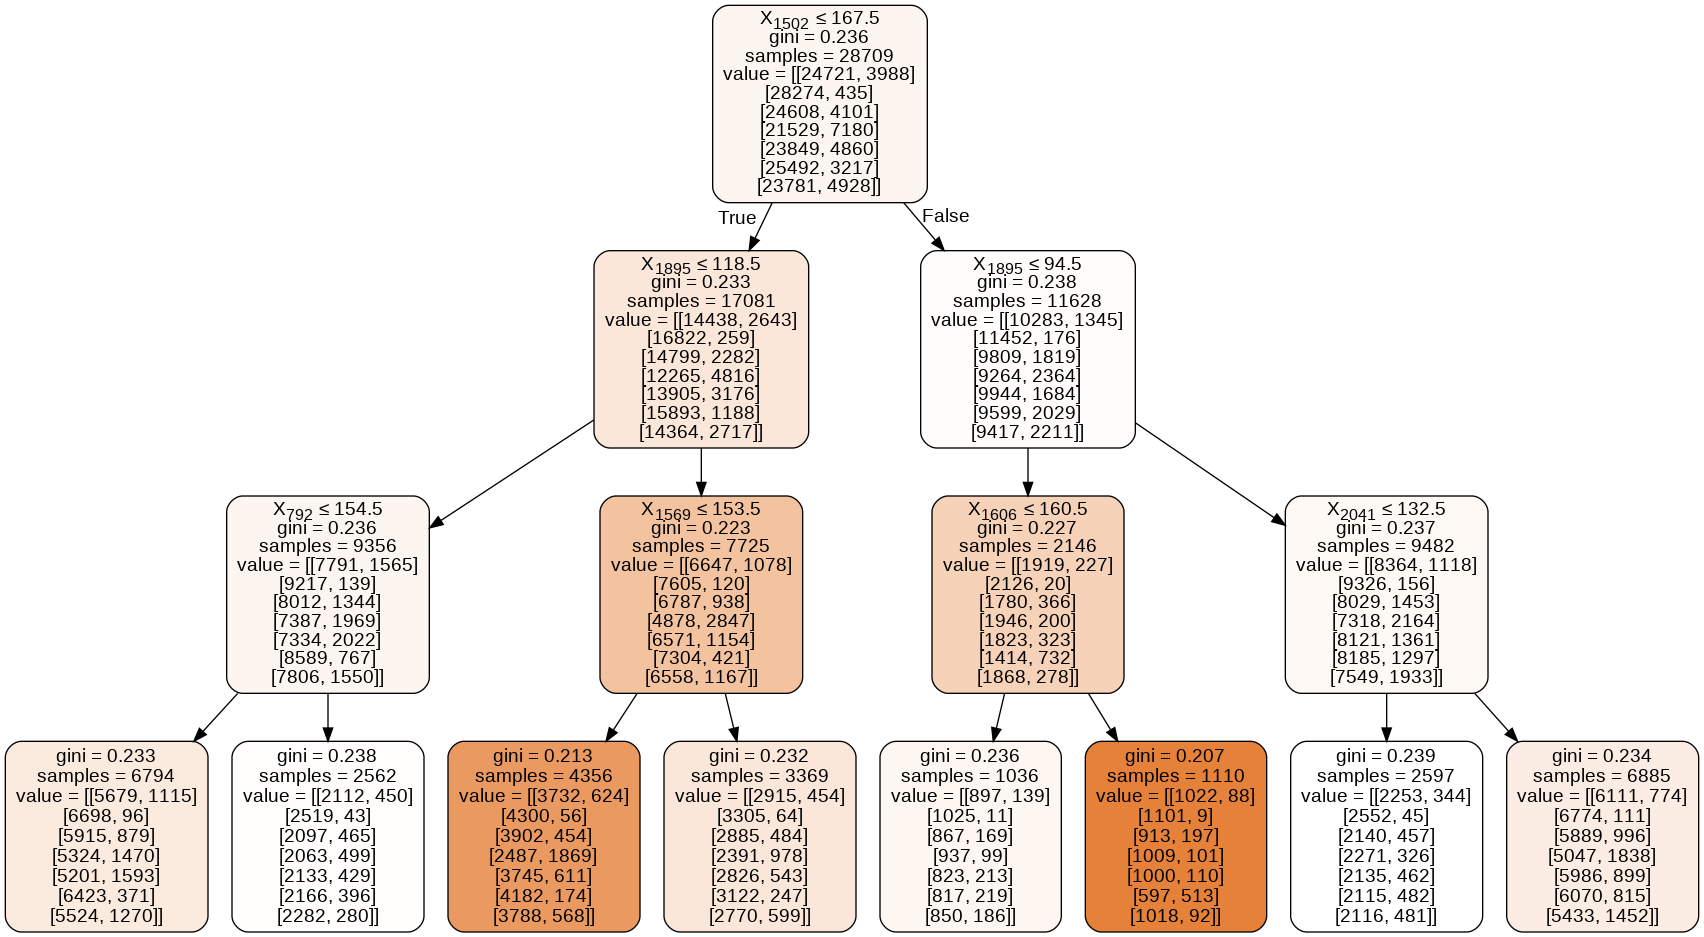

In [0]:
#create a image of the first branches of the desicion tree

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(classifier, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('tree.png')
Image(graph.create_png())

Feed Forward Model


In [0]:
#change the shape of data, from a matrix to array

dimData= np.prod(X_train.shape[1:])
train_data = X_train.reshape(X_train.shape[0], dimData)
test_data = X_test.reshape(X_test.shape[0], dimData)
val_data = X_val.reshape(X_val.shape[0], dimData)

In [0]:
# Change to float datatype
train_data = train_data.astype('float32')
test_data = test_data.astype('float32')
val_data = val_data.astype('float32')

In [0]:
# Scale the data to lie between 0 to 1

train_data /= 255.
test_data /= 255.
val_data /= 255.

In [0]:
#setting feedforward model

model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(dimData,)))
model.add(Dense(512, activation='relu'))
model.add(Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               1180160   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 3591      
Total params: 1,446,407
Trainable params: 1,446,407
Non-trainable params: 0
_________________________________________________________________


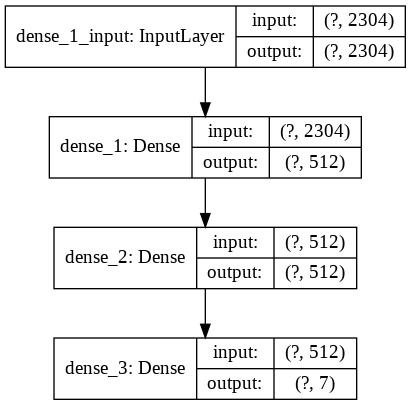

In [0]:
tf.keras.utils.plot_model(model, 'forward_model.png', show_shapes=True)

In [0]:
#train model

history = model.fit(train_data, y_train, batch_size=128, epochs=200, verbose=2, validation_data=(val_data, y_val))

Train on 28709 samples, validate on 3589 samples
Epoch 1/200
 - 3s - loss: 1.7881 - accuracy: 0.2852 - val_loss: 1.7329 - val_accuracy: 0.3037
Epoch 2/200
 - 2s - loss: 1.6873 - accuracy: 0.3354 - val_loss: 1.6809 - val_accuracy: 0.3369
Epoch 3/200
 - 2s - loss: 1.6588 - accuracy: 0.3463 - val_loss: 1.6278 - val_accuracy: 0.3823
Epoch 4/200
 - 2s - loss: 1.6427 - accuracy: 0.3572 - val_loss: 1.6130 - val_accuracy: 0.3764
Epoch 5/200
 - 2s - loss: 1.6199 - accuracy: 0.3642 - val_loss: 1.6194 - val_accuracy: 0.3753
Epoch 6/200
 - 2s - loss: 1.6039 - accuracy: 0.3714 - val_loss: 1.6477 - val_accuracy: 0.3461
Epoch 7/200
 - 2s - loss: 1.5949 - accuracy: 0.3728 - val_loss: 1.6484 - val_accuracy: 0.3511
Epoch 8/200
 - 2s - loss: 1.5815 - accuracy: 0.3832 - val_loss: 1.5795 - val_accuracy: 0.3867
Epoch 9/200
 - 2s - loss: 1.5585 - accuracy: 0.3935 - val_loss: 1.5932 - val_accuracy: 0.3853
Epoch 10/200
 - 2s - loss: 1.5561 - accuracy: 0.3915 - val_loss: 1.5629 - val_accuracy: 0.3912
Epoch 11/2

In [0]:
# model.save('/content/drive/My Drive/feedforward_model.h5')

In [0]:
# model = load_model('/content/drive/My Drive/feedforward_model.h5')

In [0]:
#evaluate accuracy achieved in test data 

scores = model.evaluate(test_data, y_test)

3589/3589 [==============================] - 0s 68us/step


In [0]:
print("Accuracy: ", scores[1]*100, "%")

Accuracy:  41.1813884973526 %


In [0]:
#train accuracy and loss

loss = model.evaluate(train_data, y_train) 
print("Train Loss " + str(loss[0]))
print("Train Acc: " + str(loss[1]))

28709/28709 [==============================] - 2s 61us/step
Train Loss 0.2665149511586387
Train Acc: 0.9070326089859009


In [0]:
#validation accuracy and loss

loss = model.evaluate(val_data, y_val) 
print("Val Loss " + str(loss[0]))
print("Val Acc: " + str(loss[1]))

3589/3589 [==============================] - 0s 67us/step
Val Loss 4.638279082350626
Val Acc: 0.4109779894351959


In [0]:
#test accuracy and loss

loss = model.evaluate(test_data, y_test) 
print("Test Loss " + str(loss[0]))
print("Test Acc: " + str(loss[1]))

3589/3589 [==============================] - 0s 63us/step
Test Loss 4.592080668972607
Test Acc: 0.411813884973526


<Figure size 432x288 with 0 Axes>

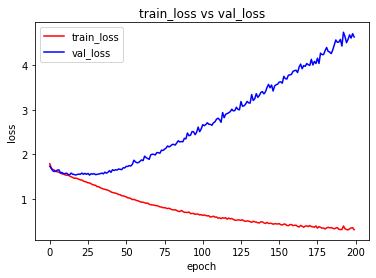

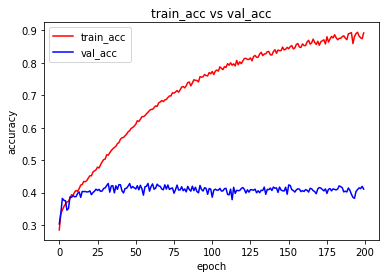

<Figure size 432x288 with 0 Axes>

In [0]:
# visualizing losses and accuracy
%matplotlib inline

train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.figure()

In [0]:
y_pred_ = model.predict(test_data, verbose=1)
y_pred = np.argmax(y_pred_, axis=1)
t_te = np.argmax(y_test, axis=1)

3589/3589 [==============================] - 0s 35us/step


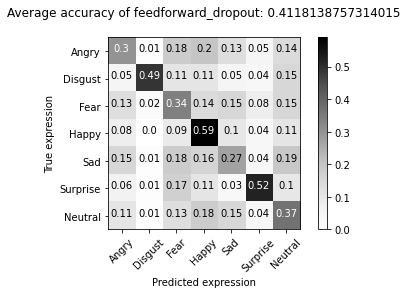

In [0]:
fig = plot_confusion_matrix(y_test=t_te, y_pred=y_pred,
                      classes=classes,
                      normalize=True,
                      cmap=plt.cm.Greys,
                      title='Average accuracy of feedforward_dropout: ' + str(np.sum(y_pred == t_te)/len(t_te)) + '\n')

In [0]:
#store precision, recall, and fscore

ff_precision, ff_recall, ff_fscore = get_statistics(y_test, y_pred_)

Feedforward dropout

In [0]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(dimData,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 512)               1180160   
_________________________________________________________________
dense_20 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 7)                 3591      
Total params: 1,446,407
Trainable params: 1,446,407
Non-trainable params: 0
_________________________________________________________________


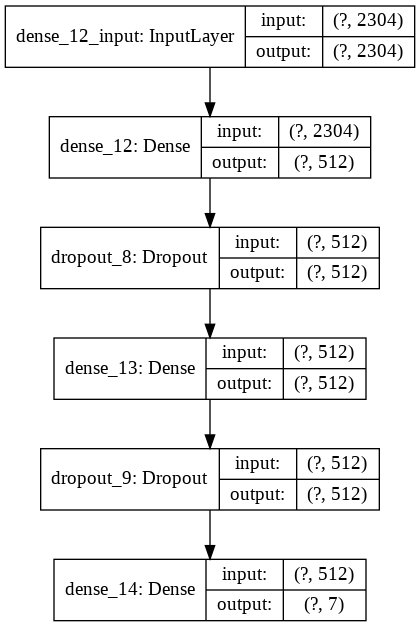

In [0]:
tf.keras.utils.plot_model(model, 'forward_model.png', show_shapes=True)

In [0]:
history = model.fit(train_data, y_train, batch_size=128, epochs=200, verbose=2, validation_data=(val_data, y_val))

Train on 28709 samples, validate on 3589 samples
Epoch 1/200
 - 1s - loss: 1.8464 - accuracy: 0.2516 - val_loss: 1.7569 - val_accuracy: 0.2903
Epoch 2/200
 - 1s - loss: 1.7369 - accuracy: 0.3011 - val_loss: 1.6865 - val_accuracy: 0.3589
Epoch 3/200
 - 1s - loss: 1.7076 - accuracy: 0.3168 - val_loss: 1.6840 - val_accuracy: 0.3508
Epoch 4/200
 - 1s - loss: 1.7166 - accuracy: 0.3107 - val_loss: 1.6686 - val_accuracy: 0.3327
Epoch 5/200
 - 1s - loss: 1.6984 - accuracy: 0.3215 - val_loss: 1.6542 - val_accuracy: 0.3578
Epoch 6/200
 - 1s - loss: 1.6896 - accuracy: 0.3266 - val_loss: 1.6583 - val_accuracy: 0.3647
Epoch 7/200
 - 1s - loss: 1.6856 - accuracy: 0.3268 - val_loss: 1.6732 - val_accuracy: 0.3502
Epoch 8/200
 - 1s - loss: 1.6776 - accuracy: 0.3322 - val_loss: 1.6414 - val_accuracy: 0.3592
Epoch 9/200
 - 1s - loss: 1.6797 - accuracy: 0.3308 - val_loss: 1.6445 - val_accuracy: 0.3547
Epoch 10/200
 - 1s - loss: 1.6803 - accuracy: 0.3312 - val_loss: 1.6600 - val_accuracy: 0.3497
Epoch 11/2

In [0]:
model.save('/content/drive/My Drive/feedforward_dropout_model.h5')

In [0]:
model = load_model('/content/drive/My Drive/feedforward_dropout_model.h5')

In [0]:
scores = model.evaluate(test_data, y_test)

3589/3589 [==============================] - 0s 88us/step


In [0]:
print("Accuracy: ", scores[1]*100, "%")

Accuracy:  36.9462251663208 %


In [0]:
loss = model.evaluate(train_data, y_train) 
print("Train Loss " + str(loss[0]))
print("Train Acc: " + str(loss[1]))

28709/28709 [==============================] - 2s 65us/step
Train Loss 1.528096435593979
Train Acc: 0.4112647473812103


In [0]:
loss = model.evaluate(test_data, y_test) 
print("Test Loss " + str(loss[0]))
print("Test Acc: " + str(loss[1]))

3589/3589 [==============================] - 0s 71us/step
Test Loss 1.6358076905632923
Test Acc: 0.369462251663208


In [0]:
loss = model.evaluate(val_data, y_val) 
print("Val Loss " + str(loss[0]))
print("Val Acc: " + str(loss[1]))

3589/3589 [==============================] - 0s 65us/step
Val Loss 1.6700423518473406
Val Acc: 0.36361104249954224


<Figure size 432x288 with 0 Axes>

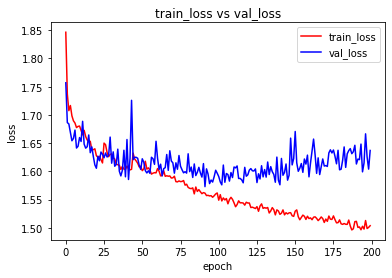

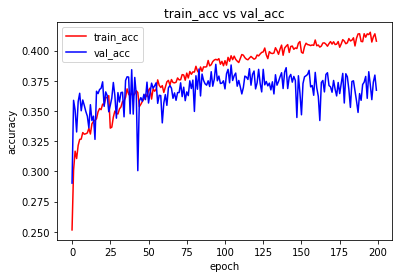

<Figure size 432x288 with 0 Axes>

In [0]:
# visualizing losses and accuracy
%matplotlib inline

train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.figure()

In [0]:
y_pred_ = model.predict(test_data, verbose=1)
y_pred = np.argmax(y_pred_, axis=1)
t_te = np.argmax(y_test, axis=1)

3589/3589 [==============================] - 2s 469us/step


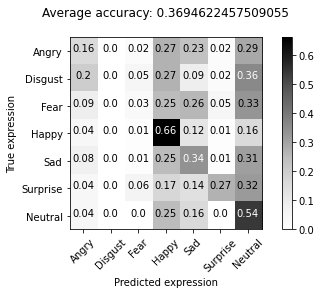

In [0]:
fig = plot_confusion_matrix(y_test=t_te, y_pred=y_pred,
                      classes=classes,
                      normalize=True,
                      cmap=plt.cm.Greys,
                      title='Average accuracy: ' + str(np.sum(y_pred == t_te)/len(t_te)) + '\n')

Simple CNN model

In [0]:
# construct the image generator for data augmentation
datagen = ImageDataGenerator( 
    rescale=1./255)

testgen = ImageDataGenerator( 
    rescale=1./255
    )
datagen.fit(X_train)
batch_size = 128

In [0]:
train_flow = datagen.flow(X_train, y_train, batch_size=batch_size) 
val_flow = testgen.flow(X_val, y_val, batch_size=batch_size) 
test_flow = testgen.flow(X_test, y_test, batch_size=batch_size) 

In [0]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape = (48, 48, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(7, activation='softmax'))

model.compile(optimizer= 'adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 30976)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3965056   
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 903       
Total params: 3,984,775
Trainable params: 3,984,775
Non-trainable params: 0
____________________________________________

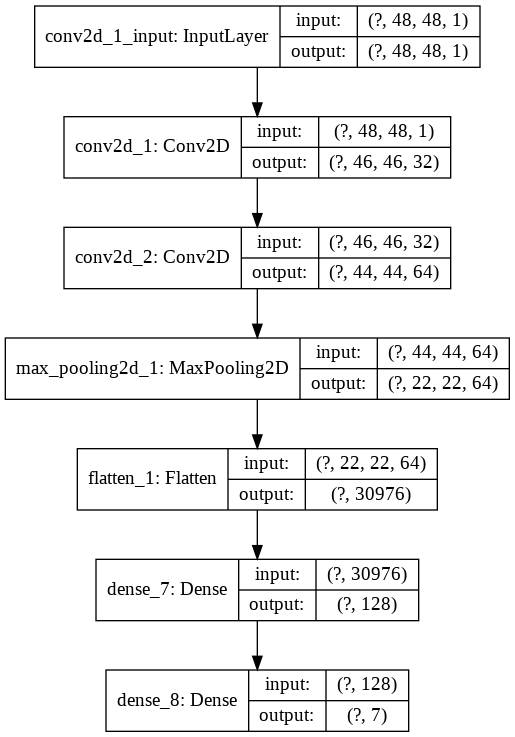

In [0]:
tf.keras.utils.plot_model(model, 'simple_cnn_model.png', show_shapes=True)

In [0]:
# we iterate 200 times over the entire training set 
num_epochs = 200
history = model.fit_generator(train_flow, 
                    steps_per_epoch=len(X_train) / batch_size, 
                    epochs=num_epochs,  
                    verbose=2,
                    validation_data=(X_val/255., y_val),  
                    validation_steps=len(X_val) / batch_size)

Epoch 1/200
 - 9s - loss: 1.5761 - accuracy: 0.3865 - val_loss: 1.4153 - val_accuracy: 0.4503
Epoch 2/200
 - 3s - loss: 1.3349 - accuracy: 0.4975 - val_loss: 1.3549 - val_accuracy: 0.4815
Epoch 3/200
 - 3s - loss: 1.2035 - accuracy: 0.5520 - val_loss: 1.3215 - val_accuracy: 0.5038
Epoch 4/200
 - 3s - loss: 1.0574 - accuracy: 0.6098 - val_loss: 1.3169 - val_accuracy: 0.5065
Epoch 5/200
 - 3s - loss: 0.8890 - accuracy: 0.6786 - val_loss: 1.3478 - val_accuracy: 0.5146
Epoch 6/200
 - 3s - loss: 0.6895 - accuracy: 0.7582 - val_loss: 1.4632 - val_accuracy: 0.5238
Epoch 7/200
 - 3s - loss: 0.4883 - accuracy: 0.8341 - val_loss: 1.6930 - val_accuracy: 0.5127
Epoch 8/200
 - 3s - loss: 0.3137 - accuracy: 0.9018 - val_loss: 1.9490 - val_accuracy: 0.5116
Epoch 9/200
 - 3s - loss: 0.1922 - accuracy: 0.9461 - val_loss: 2.2704 - val_accuracy: 0.5021
Epoch 10/200
 - 3s - loss: 0.1120 - accuracy: 0.9734 - val_loss: 2.5936 - val_accuracy: 0.5127
Epoch 11/200
 - 3s - loss: 0.0815 - accuracy: 0.9830 - val_

<Figure size 432x288 with 0 Axes>

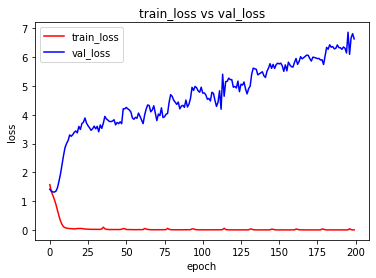

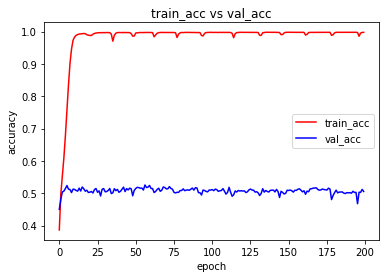

<Figure size 432x288 with 0 Axes>

In [0]:
# visualizing losses and accuracy
%matplotlib inline

train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.figure()

In [0]:
# Save entire model to a HDF5 file
model.save('/content/drive/My Drive/simple_cnn.h5')

In [0]:
# Load entire trained model as a HDF5 file
model = load_model('/content/drive/My Drive/simple_cnn.h5')

In [0]:
loss = model.evaluate_generator(test_flow, steps=len(X_test) / batch_size) 
print("Test Loss " + str(loss[0]))
print("Test Acc: " + str(loss[1]))

Test Loss 6.379769325256348
Test Acc: 0.5243800282478333


In [0]:
loss = model.evaluate(X_train/255., y_train) 
print("Train Loss " + str(loss[0]))
print("Train Acc: " + str(loss[1]))

28709/28709 [==============================] - 2s 82us/step
Train Loss 0.003570791188527896
Train Acc: 0.9981887340545654


In [0]:
loss = model.evaluate(X_val/255., y_val) 
print("Val Loss " + str(loss[0]))
print("Val Acc: " + str(loss[1]))

3589/3589 [==============================] - 0s 82us/step
Val Loss 6.633691618322296
Val Acc: 0.5054332613945007


In [0]:
y_pred_ = model.predict(X_test/255., verbose=1)
y_pred = np.argmax(y_pred_, axis=1)
t_te = np.argmax(y_test, axis=1)

3589/3589 [==============================] - 0s 69us/step


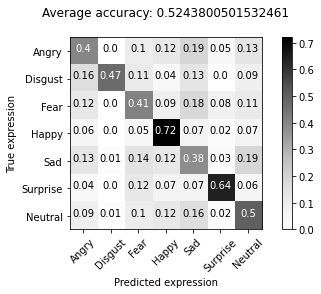

In [0]:
fig = plot_confusion_matrix(y_test=t_te, y_pred=y_pred,
                      classes=classes,
                      normalize=True,
                      cmap=plt.cm.Greys,
                      title='Average accuracy: ' + str(np.sum(y_pred == t_te)/len(t_te)) + '\n')

In [0]:
sc_precision, sc_recall, sc_fscore = get_statistics(y_test, y_pred_)

Simple CNN with DropOut

In [0]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape = (48, 48, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

model.compile(optimizer= 'adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_51 (Conv2D)           (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 44, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 22, 22, 64)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 30976)             0         
_________________________________________________________________
dense_27 (Dense)             (None, 128)               3965056   
_________________________________________________________________
dropout_42 (Dropout)         (None, 128)             

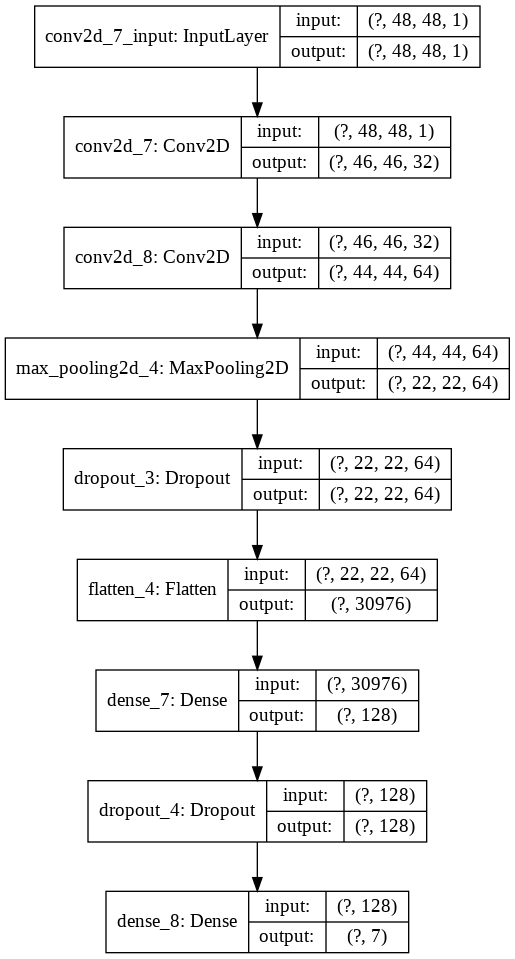

In [0]:
tf.keras.utils.plot_model(model, 'simple_cnn_dropout_model.png', show_shapes=True)

In [0]:
num_epochs = 200
history = model.fit_generator(train_flow, 
                    steps_per_epoch=len(X_train) / batch_size, 
                    epochs=num_epochs,  
                    verbose=2,
                    validation_data=(X_val/255., y_val),  
                    validation_steps=len(X_val) / batch_size)

Epoch 1/200
 - 4s - loss: 1.7381 - accuracy: 0.3039 - val_loss: 1.5907 - val_accuracy: 0.3853
Epoch 2/200
 - 3s - loss: 1.5437 - accuracy: 0.4013 - val_loss: 1.4386 - val_accuracy: 0.4478
Epoch 3/200
 - 3s - loss: 1.4437 - accuracy: 0.4423 - val_loss: 1.3808 - val_accuracy: 0.4756
Epoch 4/200
 - 3s - loss: 1.3807 - accuracy: 0.4679 - val_loss: 1.3653 - val_accuracy: 0.4712
Epoch 5/200
 - 3s - loss: 1.3240 - accuracy: 0.4960 - val_loss: 1.3233 - val_accuracy: 0.4918
Epoch 6/200
 - 3s - loss: 1.2692 - accuracy: 0.5121 - val_loss: 1.3239 - val_accuracy: 0.4904
Epoch 7/200
 - 3s - loss: 1.2206 - accuracy: 0.5308 - val_loss: 1.2922 - val_accuracy: 0.4999
Epoch 8/200
 - 3s - loss: 1.1684 - accuracy: 0.5495 - val_loss: 1.3016 - val_accuracy: 0.5093
Epoch 9/200
 - 3s - loss: 1.1229 - accuracy: 0.5701 - val_loss: 1.2905 - val_accuracy: 0.5163
Epoch 10/200
 - 3s - loss: 1.0760 - accuracy: 0.5861 - val_loss: 1.3197 - val_accuracy: 0.5113
Epoch 11/200
 - 3s - loss: 1.0359 - accuracy: 0.6001 - val_

<Figure size 432x288 with 0 Axes>

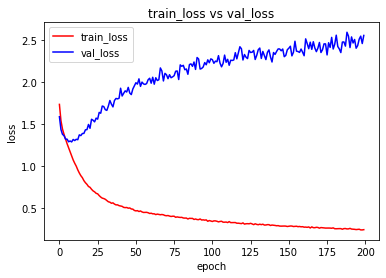

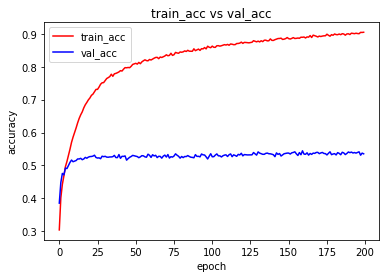

<Figure size 432x288 with 0 Axes>

In [0]:
# visualizing losses and accuracy
%matplotlib inline

train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.figure()

In [0]:
# Save entire model to a HDF5 file
model.save('/content/drive/My Drive/simple_cnn_dropout.h5')

In [0]:
# Load entire trained model as a HDF5 file
model = load_model('/content/drive/My Drive/simple_cnn_dropout.h5.h5')

In [0]:
loss = model.evaluate_generator(test_flow, steps=len(X_test) / batch_size) 
print("Test Loss " + str(loss[0]))
print("Test Acc: " + str(loss[1]))

Test Loss 1.34940505027771
Test Acc: 0.5519643425941467


In [0]:
loss = model.evaluate(X_train/255., y_train) 
print("Train Loss " + str(loss[0]))
print("Train Acc: " + str(loss[1]))

28709/28709 [==============================] - 3s 105us/step
Train Loss 0.011376339250285951
Train Acc: 0.9972831010818481


In [0]:
loss = model.evaluate(X_val/255., y_val) 
print("Val Loss " + str(loss[0]))
print("Val Acc: " + str(loss[1]))

3589/3589 [==============================] - 0s 108us/step
Val Loss 2.559426280043191
Val Acc: 0.5352466106414795


In [0]:
y_pred_ = model.predict(X_test/255., verbose=1)
y_pred = np.argmax(y_pred_, axis=1)
t_te = np.argmax(y_test, axis=1)

3589/3589 [==============================] - 0s 91us/step


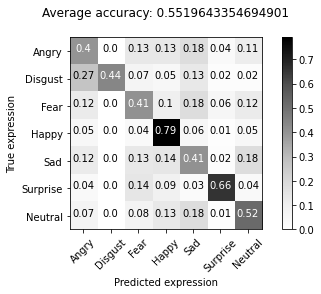

In [0]:
fig = plot_confusion_matrix(y_test=t_te, y_pred=y_pred,
                      classes=classes,
                      normalize=True,
                      cmap=plt.cm.Greys,
                      title='Average accuracy: ' + str(np.sum(y_pred == t_te)/len(t_te)) + '\n')

Final CNN

In [0]:
# construct the image generator for data augmentation
datagen = ImageDataGenerator( 
    rotation_range = 10,
    horizontal_flip = True,
    zoom_range=0.1,
    fill_mode = 'nearest',
    rescale=1./255
      )

testgen = ImageDataGenerator( 
    rescale=1./255
    )
datagen.fit(X_train)
batch_size = 128

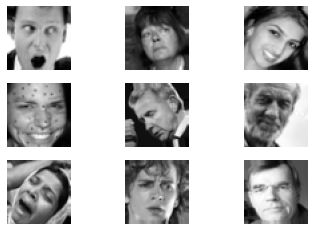

In [0]:
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    for i in range(0, 9): 
        plt.axis('off') 
        plt.subplot(330 + 1 + i) 
        plt.imshow(X_batch[i].reshape(48, 48), cmap=plt.get_cmap('gray'))
    plt.axis('off') 
    plt.show() 
    break

In [0]:
train_flow = datagen.flow(X_train, y_train, batch_size=batch_size) 
val_flow = testgen.flow(X_val, y_val, batch_size=batch_size) 
test_flow = testgen.flow(X_test, y_test, batch_size=batch_size)

In [0]:
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape = (48, 48, 1)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))
    
    model.add(Flatten())

    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Dense(7, activation='softmax'))
    
    opt = Adam(lr=0.001, decay=10e-6)
    model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 128)      

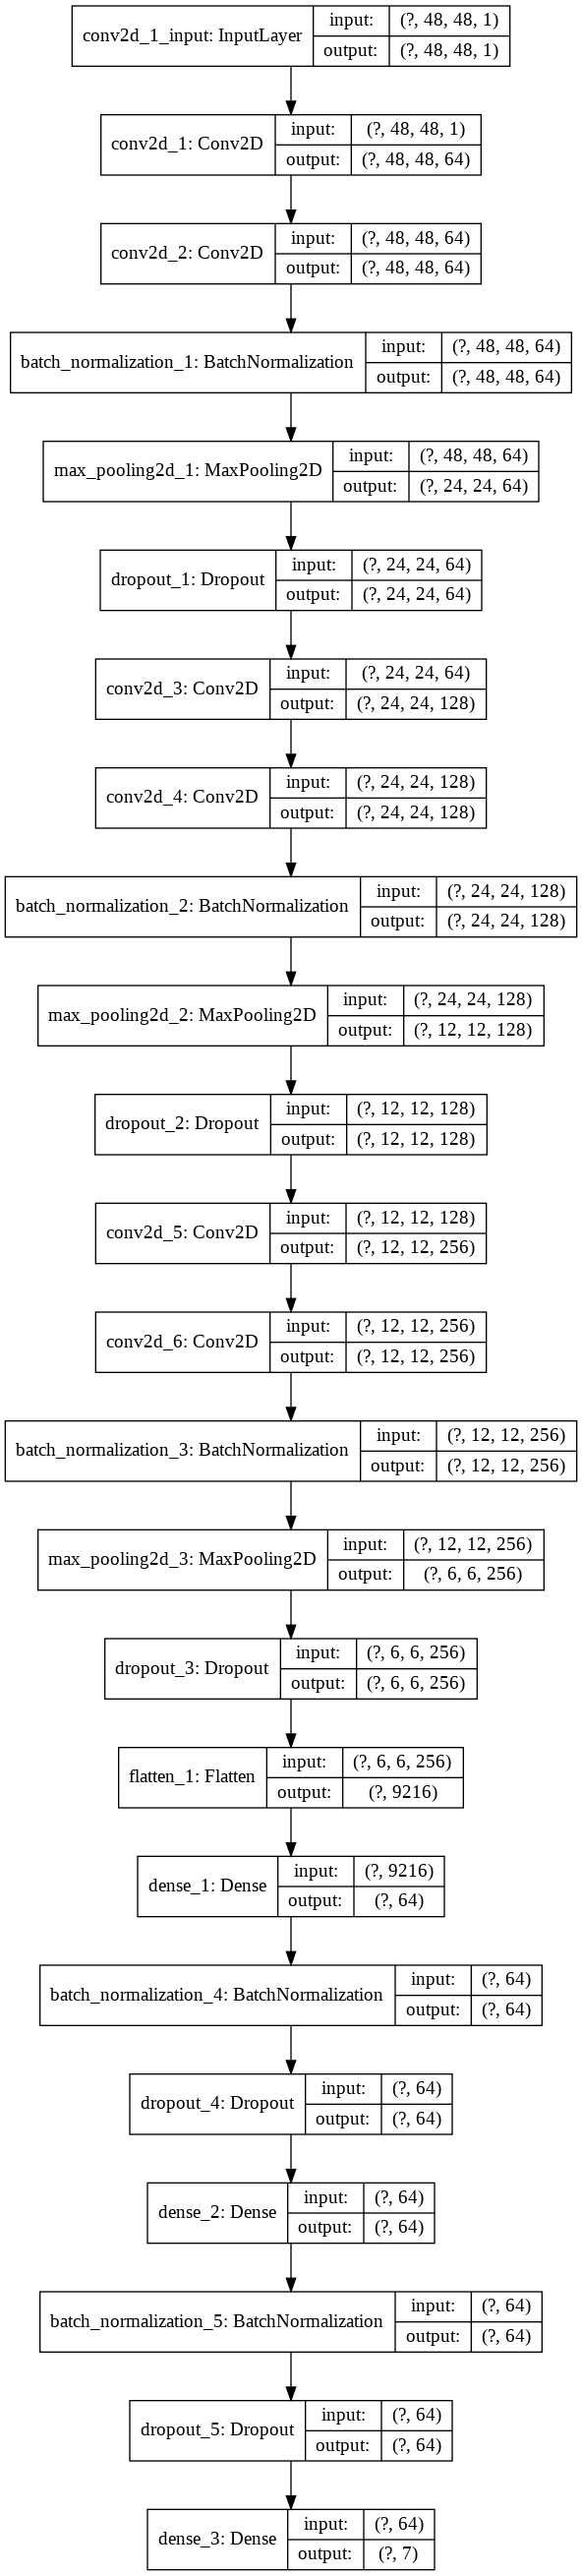

In [0]:
tf.keras.utils.plot_model(model, 'cnn1.png', show_shapes=True)

In [0]:
#setting early stopping

early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=80, mode='auto')

In [0]:
num_epochs = 200
history = model.fit_generator(train_flow, 
                    steps_per_epoch=len(X_train) / batch_size, 
                    epochs=num_epochs,  
                    verbose=2,
                    callbacks= [early_stopper],
                    validation_data=(X_val/255., y_val),  
                    validation_steps=len(X_val) / batch_size)

Epoch 1/200
 - 14s - loss: 2.1726 - accuracy: 0.2046 - val_loss: 2.1468 - val_accuracy: 0.2494
Epoch 2/200
 - 13s - loss: 1.8322 - accuracy: 0.2786 - val_loss: 1.8510 - val_accuracy: 0.3043
Epoch 3/200
 - 13s - loss: 1.6582 - accuracy: 0.3511 - val_loss: 1.5795 - val_accuracy: 0.3748
Epoch 4/200
 - 13s - loss: 1.5278 - accuracy: 0.4060 - val_loss: 1.9359 - val_accuracy: 0.3232
Epoch 5/200
 - 13s - loss: 1.4327 - accuracy: 0.4485 - val_loss: 1.4695 - val_accuracy: 0.4341
Epoch 6/200
 - 13s - loss: 1.3642 - accuracy: 0.4803 - val_loss: 1.3921 - val_accuracy: 0.4700
Epoch 7/200
 - 13s - loss: 1.3142 - accuracy: 0.5001 - val_loss: 1.2397 - val_accuracy: 0.5205
Epoch 8/200
 - 13s - loss: 1.2778 - accuracy: 0.5144 - val_loss: 1.3894 - val_accuracy: 0.4706
Epoch 9/200
 - 13s - loss: 1.2539 - accuracy: 0.5322 - val_loss: 1.2530 - val_accuracy: 0.5247
Epoch 10/200
 - 13s - loss: 1.2224 - accuracy: 0.5418 - val_loss: 1.1594 - val_accuracy: 0.5575
Epoch 11/200
 - 13s - loss: 1.2030 - accuracy: 0.

In [0]:
# Save entire model to a HDF5 file
model.save('/content/drive/My Drive/finalcnn.h5')

In [0]:
model= load_model('/content/drive/My Drive/finalcnn.h5')

In [0]:
loss = model.evaluate_generator(test_flow, steps=len(X_test) / batch_size) 
print("Test Loss " + str(loss[0]))
print("Test Acc: " + str(loss[1]))

Test Loss 0.738530158996582
Test Acc: 0.6974087357521057


In [0]:
loss = model.evaluate(X_train/255., y_train) 
print("Train Loss " + str(loss[0]))
print("Train Acc: " + str(loss[1]))

28709/28709 [==============================] - 6s 218us/step
Train Loss 0.274037624482779
Train Acc: 0.906997799873352


In [0]:
loss = model.evaluate(X_val/255., y_val) 
print("Val Loss " + str(loss[0]))
print("Val Acc: " + str(loss[1]))

3589/3589 [==============================] - 1s 213us/step
Val Loss 1.043039232118776
Val Acc: 0.675954282283783


<Figure size 432x288 with 0 Axes>

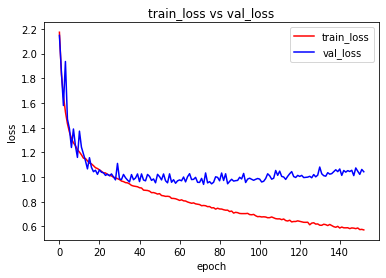

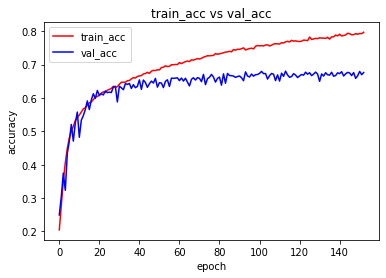

<Figure size 432x288 with 0 Axes>

In [0]:
# visualizing losses and accuracy
%matplotlib inline

train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.figure()

In [0]:
y_pred_ = model.predict(X_test/255., verbose=1)
y_pred = np.argmax(y_pred_, axis=1)
t_te = np.argmax(y_test, axis=1)

3589/3589 [==============================] - 1s 219us/step


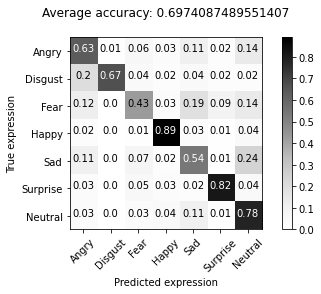

In [0]:
fig = plot_confusion_matrix(y_test=t_te, y_pred=y_pred,
                      classes=classes,
                      normalize=True,
                      cmap=plt.cm.Greys,
                      title='Average accuracy: ' + str(np.sum(y_pred == t_te)/len(t_te)) + '\n')

In [0]:
c_precision, c_recall, c_fscore = get_statistics(y_test, y_pred_)

Precision, Recall, Fscore Plot bars

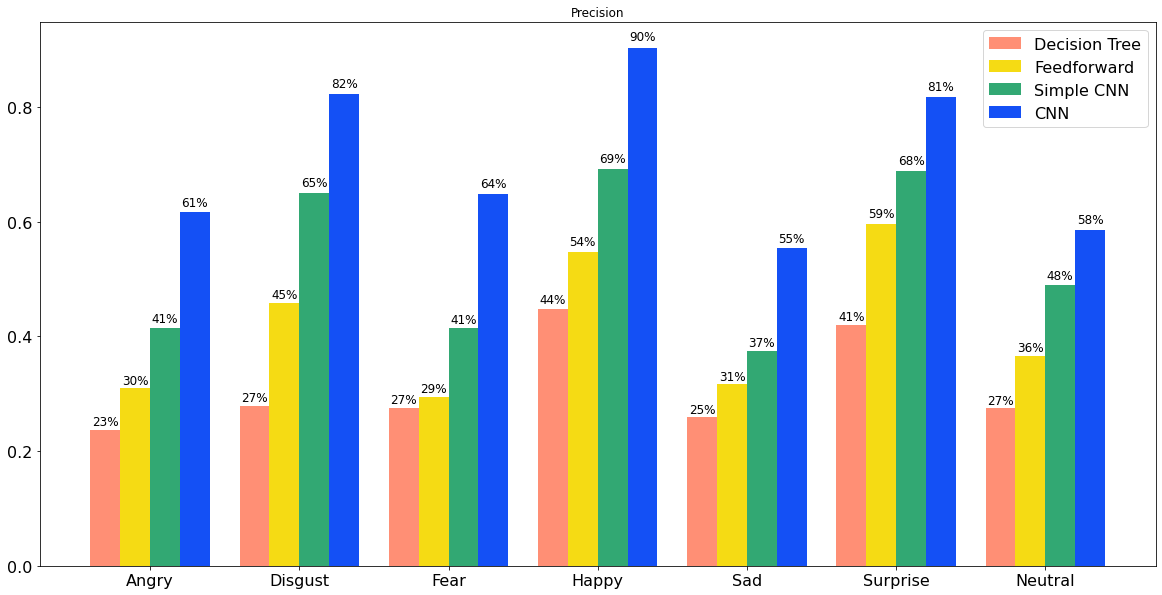

In [0]:
plot_bar(dt_precision, ff_precision, sc_precision, c_precision, 'Precision')

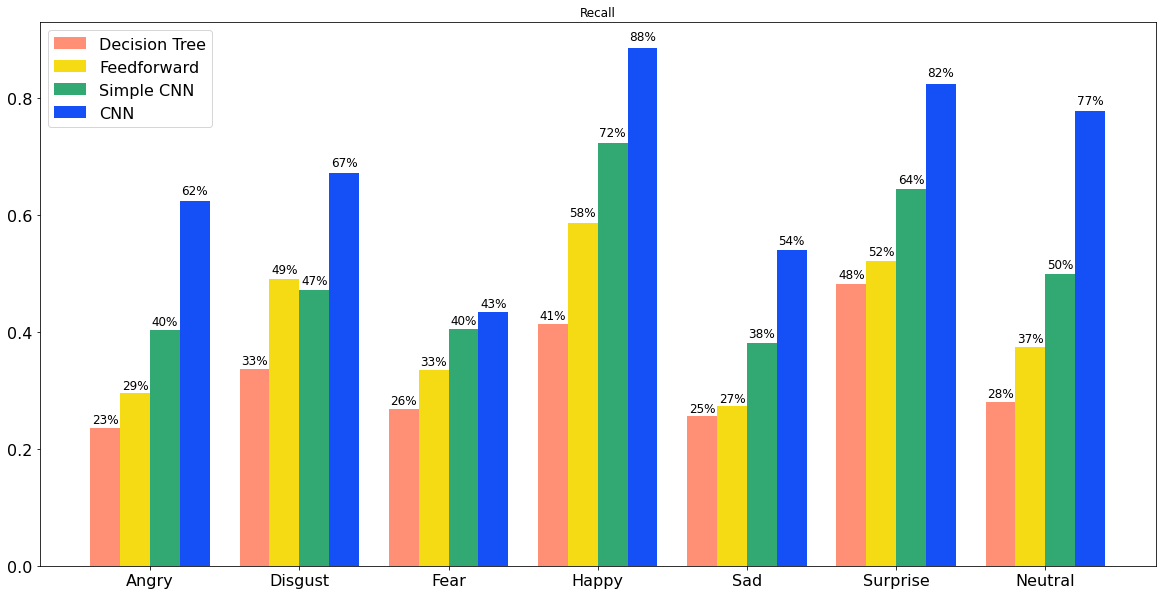

In [0]:
plot_bar(dt_recall, ff_recall, sc_recall, c_recall, 'Recall')

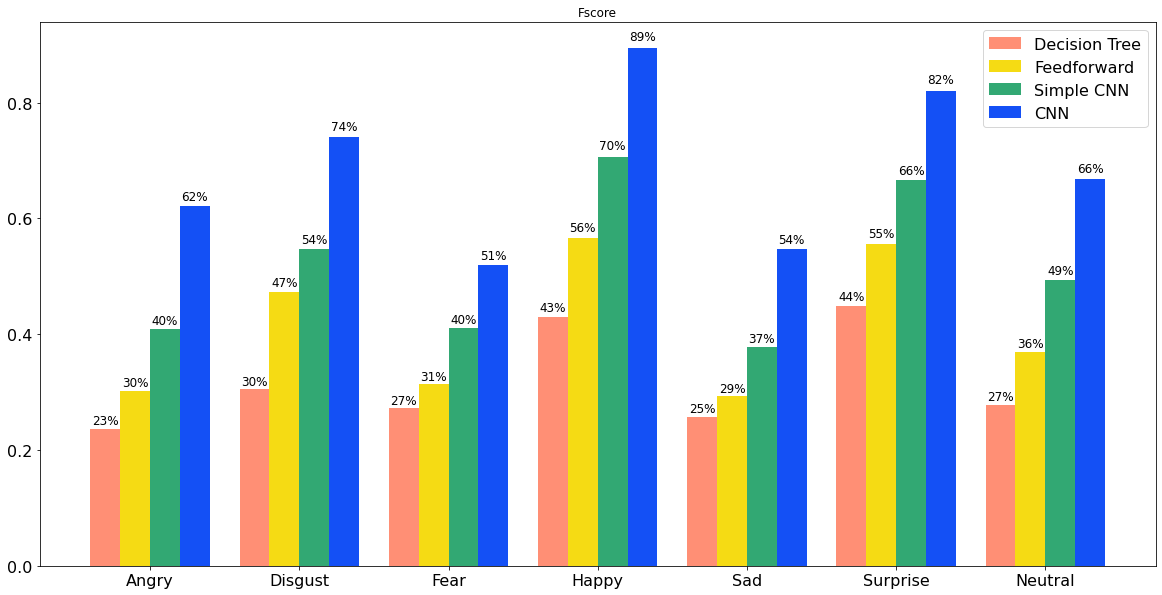

In [0]:
plot_bar(dt_fscore, ff_fscore, sc_fscore, c_fscore, 'Fscore')

In [0]:
Live video test

In [0]:
from keras.preprocessing import image

#load model
model = load_model("finalcnn.h5")

#load cascade
face_haar_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

#start video capture
cap= cv2.VideoCapture(0)

while True:
    ret, test_img= cap.read()# captures frame and returns boolean value and captured image
    if not ret:
        continue
    gray_img= cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)  #downgrade image to gray

    faces_detected = face_haar_cascade.detectMultiScale(gray_img, 1.32, 5)

    for (x, y, w, h) in faces_detected:
        cv2.rectangle(test_img,(x,y),(x+w,y+h),(255,0,0),thickness=7)
        roi_gray=gray_img[y:y+w,x:x+h]           #cropping region of interest i.e. face area from  image
        roi_gray=cv2.resize(roi_gray,(48,48))
        img_pixels = image.img_to_array(roi_gray)
        img_pixels = np.expand_dims(img_pixels, axis = 0)
        img_pixels /= 255

        predictions = model.predict(img_pixels)   #predict result

        max_index = np.argmax(predictions[0])     #take the max index in the array

        emotions = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
        predicted_emotion = emotions[max_index]

        cv2.putText(test_img, predicted_emotion, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)    #show emotions in came

    resized_img = cv2.resize(test_img, (1000, 700))
    cv2.imshow('Facial emotion analysis ', resized_img)



    if cv2.waitKey(10) == ord('q'): #close camera using Q
        break

cap.release()